In [0]:
#download these folder and test file from google drive for pre trained VQA model
#https://drive.google.com/drive/folders/1vlVDWGP_xwBaqZnFFTRwpSDriLxu-tHM?usp=sharing


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os, argparse
import keras
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [0]:
# File paths for the model, all of these except the CNN Weights are 
# provided in the repo, See the models/CNN/README.md to download VGG weights
VQA_model_file_name      = 'VQA/VQA_MODEL.json'
VQA_weights_file_name   = 'VQA/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = 'VQA/FULL_labelencoder_trainval.pkl'

In [0]:
def get_image_model():
    from keras.applications.vgg16 import VGG16
    model = VGG16(weights='imagenet')
    from keras.models import Model

    new_input = model.input
    hidden_layer = model.layers[-2].output

    model_new = Model(new_input, hidden_layer)
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model_new.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model_new

In [4]:
model_vgg = get_image_model()
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0         
__________

In [0]:
def get_image_features(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))
    # Magic_Number = 4096  > Comes from last layer of VGG Model

    # Since VGG was trained as a image of 224x224, every new image
    # is required to go through the same transformation
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # convert the image to RGBA

    
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = model_vgg.predict(im)[0]
    return image_features

In [0]:
def get_question_features(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_vectors_web_lg')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    for j in range(len(tokens)):
        question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

In [0]:
##If there is any error with "en_vectors_web_lg" run the following:
#!python -m spacy download en_vectors_web_lg

In [0]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
    vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [9]:
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)
model_vqa.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
__________

In [0]:
#Testing the image

image_file_name = 'test.jpg'
question = u"What vehicle is in the picture?"

In [12]:
# get the image features
image_features = get_image_features(image_file_name)
# get the question features
question_features = get_question_features(question)
y_output = model_vqa.predict([question_features, image_features])

# This task here is represented as a classification into a 1000 top answers
# this means some of the answers were not part of training and thus would 
# not show up in the result.
# These 1000 answers are stored in the sklearn Encoder class


warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print(str(round(y_output[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(label))

98.96 %  train
00.61 %  bicycle
00.25 %  bus
00.06 %  bike
00.03 %  train station


In [13]:
#Test your own images (for now upload exactly 5 images):

from google.colab import files
uploaded = files.upload()
from IPython.display import Image, display

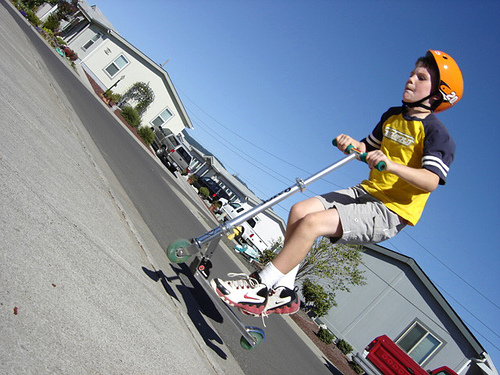

What is the boy doing in the picture?
61.76 %  skateboarding
18.06 %  snowboarding
17.59 %  skiing
000.3 %  catching frisbee
00.25 %  brushing teeth


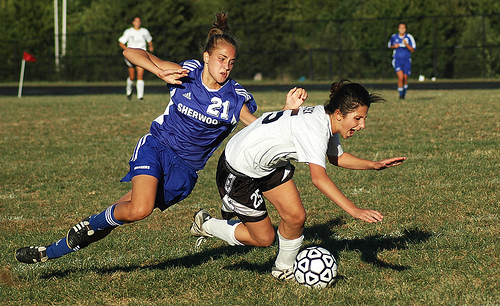

What are the chilren playing in the picture?
97.44 %  frisbee
02.15 %  soccer ball
00.34 %  soccer
00.04 %  ball
00.02 %  kite


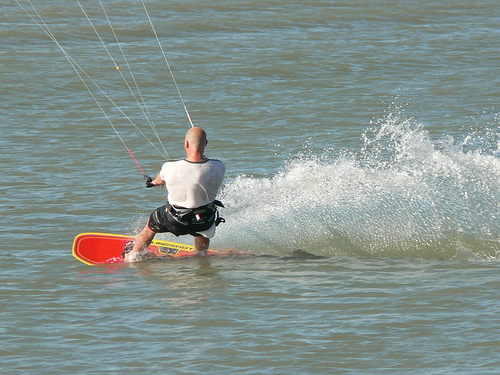

What is the man doing?
94.92 %  surfing
03.32 %  water skiing
00.87 %  parasailing
000.4 %  swimming
00.07 %  sitting


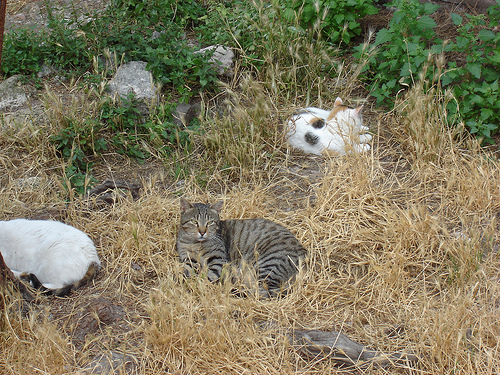

What color is the cat?
39.35 %  white
28.76 %  brown
019.5 %  black
05.56 %  blue
02.01 %  tan


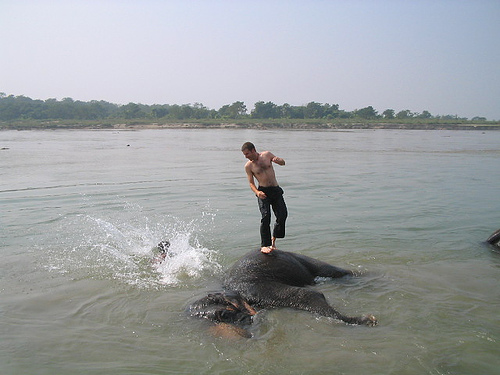

What is in this picture?
35.59 %  surfer
16.91 %  waves
13.05 %  frisbee
12.66 %  surfboard
04.38 %  wave


In [16]:
#change the lists with your images and questions

image_file_names = ['47870024_73a4481f7d.jpg', '47871819_db55ac4699.jpg','49553964_cee950f3ba.jpg','50030244_02cd4de372.jpg','53043785_c468d6f931.jpg']
questions = [ u"What is the boy doing in the picture?" , u"What are the chilren playing in the picture?", u"What is the man doing?", u"What color is the cat?" , u"What is in this picture?"]

for i in range(0,5):
    question = questions[i]
    image_file_name = image_file_names[i]
    display(Image(image_file_name))
    print(question)
    y_output = model_vqa.predict([get_question_features(question), get_image_features(image_file_name)])
    for label in reversed(np.argsort(y_output)[0,-5:]):
        print(str(round(y_output[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(label))